In [1]:
# %matplotlib notebook
%matplotlib inline

import jzap
import replay

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import datetime
import scipy.stats
import statsmodels.api as sm
import patsy

from pdb import set_trace

import warnings
warnings.filterwarnings('ignore')

# path = '/lab/data/behavior_replay_180129-2.txt'
# path = '/lab/data/behavior_replay_180316.txt'
path = '/lab/data/behavior_replay_180518.txt'

data = jzap.misc.load_table(path)
print(data.columns)
print(data.head())

/usr/local/lib/python2.7/dist-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


Index([u'mouse', u'date', u'day_sum_eqdist_0_1_plus',
       u'day_frac_eqdist_0_1_plus', u'day_sum_eqdist_0_1_minus',
       u'day_frac_eqdist_0_1_minus', u'dprime', u'hmm_dprime',
       u'hmm_dprime_noneutral', u'hmm_dprime_run2', u'hmm_dprime_run3',
       u'hmm_dprime_run4', u'hmm_engagement', u'training_licks',
       u'lick_latency', u'running', u'replay_freq_0_1_plus',
       u'replay_freq_0_1_neutral', u'replay_freq_0_1_minus', u'n_stimuli_plus',
       u'n_stimuli_neutral', u'n_stimuli_minus', u'n_ensure', u'ncorrect_plus',
       u'ncorrect_minus', u'ncorrect_neutral', u'nfalse_plus', u'nfalse_minus',
       u'nfalse_neutral', u'hmm_ncorrect_plus', u'hmm_ncorrect_minus',
       u'hmm_ncorrect_neutral', u'hmm_nfalse_plus', u'hmm_nfalse_minus',
       u'hmm_nfalse_neutral', u'hmm_nfalse_all', u'hmm_ncorrect_all',
       u'fraction_visually_driven_50_plus',
       u'fraction_visually_driven_50_minus',
       u'fraction_visually_driven_50_neutral',
       u'fraction_visually_dri

In [2]:
pre_data = data[data['phase'].str.contains('A_pre')]
post_data = data[data['phase'].str.contains('B_post')]

mean_engage = data.hmm_engagement.mean()
mean_hmm_dprime = data.hmm_dprime.mean()
mean_d_hmm_dprime_prev = data.d_hmm_dprime_prev.mean()
data = data.assign(
    engage_cat=data.hmm_engagement < mean_engage,
    hmm_dprime_cat=data.hmm_dprime < mean_hmm_dprime,
    d_hmm_dprime_prev_cat=data.d_hmm_dprime_prev < mean_d_hmm_dprime_prev)
data.engage_cat = data.engage_cat.apply(
    lambda cat: 'low engagement' if cat else 'high engagement')
data.hmm_dprime_cat = data.hmm_dprime_cat.apply(
    lambda cat: 'low hmm dprime' if cat else 'high hmm dprime')
data.d_hmm_dprime_prev_cat = data.d_hmm_dprime_prev_cat.apply(
    lambda cat: 'worsening' if cat else 'improvement')

order = ['plus', 'minus', 'neutral']

## Split data by phase and plot behavior and reactivations over time

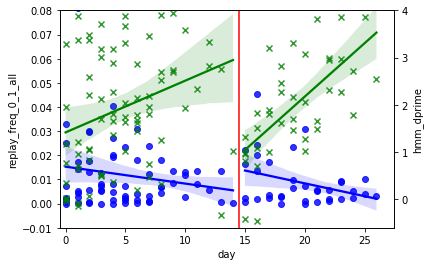

In [3]:
_, ax1 = plt.subplots()
sns.regplot(
    ax=ax1, y='replay_freq_0_1_all', x='day', data=pre_data, color='b',
    truncate=True)
sns.regplot(
    ax=ax1, y='replay_freq_0_1_all', x='day', data=post_data, color='b',
    truncate=True)
ax1.axvline(x=14.5, color='r', ls='-')
ax2 = ax1.twinx()
sns.regplot(
    ax=ax2, x='day', y='hmm_dprime', data=pre_data, color='g', marker='x',
    truncate=True)
sns.regplot(
    ax=ax2, x='day', y='hmm_dprime', data=post_data, color='g', marker='x',
    truncate=True)
ax1.set_xlim(-0.5, 27.5)
ax1.set_ylim(-0.01, 0.08)
ax2.set_ylim(-0.6, 4);

### Good example mouse: OA34

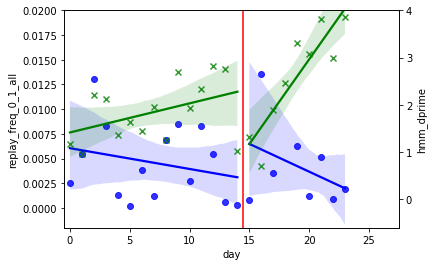

In [4]:
pre_mouse = pre_data[pre_data.mouse.str.contains('OA34')]
post_mouse = post_data[post_data.mouse.str.contains('OA34')]

_, ax1 = plt.subplots()
sns.regplot(
    ax=ax1, y='replay_freq_0_1_all', x='day', data=pre_mouse, color='b',
    truncate=True)
sns.regplot(
    ax=ax1, y='replay_freq_0_1_all', x='day', data=post_mouse, color='b',
    truncate=True)
ax1.axvline(x=14.5, color='r', ls='-')
ax2 = ax1.twinx()
sns.regplot(
    ax=ax2, x='day', y='hmm_dprime', data=pre_mouse, color='g', marker='x',
    truncate=True)
sns.regplot(
    ax=ax2, x='day', y='hmm_dprime', data=post_mouse, color='g', marker='x',
    truncate=True)
ax1.set_xlim(-0.5, 27.5)
ax1.set_ylim(-0.002, 0.02)
ax2.set_ylim(-0.6, 4);

## Overall behavior and reactivation correlation

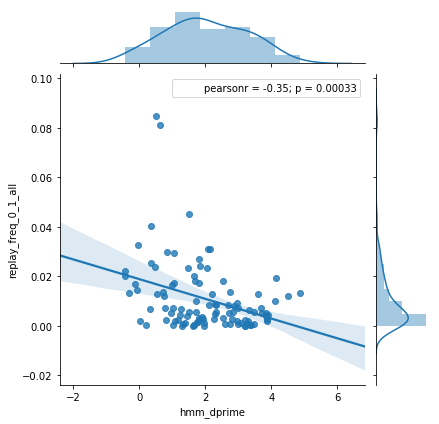

In [5]:
sns.jointplot(
    x='hmm_dprime', y='replay_freq_0_1_all', data=data, kind='reg') 

                Results: Generalized linear model
Model:              GLM                 AIC:            -694.2441
Link Function:      log                 BIC:            -319.0923
Dependent Variable: replay_freq_0_1_all Log-Likelihood: 349.12   
Date:               2018-05-21 11:22    LL-Null:        341.19   
No. Observations:   98                  Deviance:       121.06   
Df Model:           1                   Pearson chi2:   106.     
Df Residuals:       96                  Scale:          1.0994   
Method:             IRLS                                         
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept    -3.9232    0.2011  -19.5087  0.0000  -4.3173  -3.5290
hmm_dprime   -0.3184    0.0853   -3.7349  0.0002  -0.4856  -0.1513



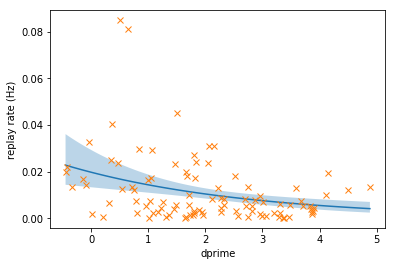

In [46]:
formula = 'replay_freq_0_1_all ~ hmm_dprime'

data_sub = data[['replay_freq_0_1_all', 'mouse', 'hmm_dprime']]
# 0s in the dependent variable still converges, but LL is infinite
data_sub.replace(0, np.nan, inplace=True)
data_sub.dropna(inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

exog = glm.exog
x_val = np.linspace(exog[:, 1].min(), exog[:, 1].max(), exog.shape[0])
exog[:, 1] = x_val
predict = glm_results.get_prediction(exog)

fig, ax = plt.subplots()
ax.plot(x_val, predict.predicted_mean)
ax.fill_between(x_val, predict.conf_int()[:, 0], predict.conf_int()[:, 1], alpha=0.3)
ax.plot(data_sub.hmm_dprime, data_sub.replay_freq_0_1_all, 'x')
ax.set_xlabel('dprime')
ax.set_ylabel('replay rate (Hz)');

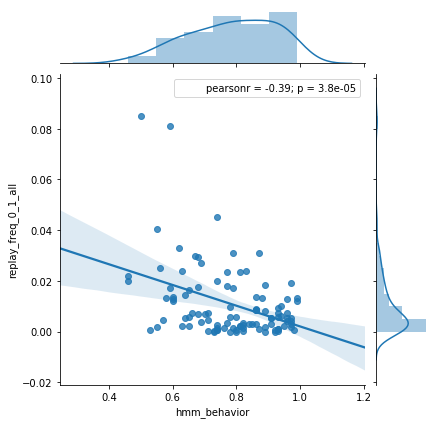

In [7]:
sns.jointplot(
    x='hmm_behavior', y='replay_freq_0_1_all', data=data, kind='reg') 

               Results: Generalized linear model
Model:              GLM                 AIC:            -inf  
Link Function:      log                 BIC:            1.0318
Dependent Variable: replay_freq_0_1_all Log-Likelihood: inf   
Date:               2018-05-18 14:31    LL-Null:        inf   
No. Observations:   103                 Deviance:       469.14
Df Model:           1                   Pearson chi2:   109.  
Df Residuals:       101                 Scale:          1.0746
Method:             IRLS                                      
--------------------------------------------------------------
                Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------
Intercept      -2.1533   0.5981 -3.5999 0.0003 -3.3256 -0.9809
hmm_behavior   -3.1623   0.7521 -4.2045 0.0000 -4.6364 -1.6881



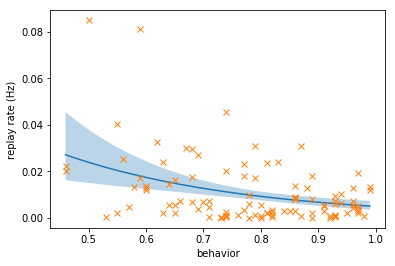

In [8]:
formula = 'replay_freq_0_1_all ~ hmm_behavior'

data_sub = data[['replay_freq_0_1_all', 'mouse', 'hmm_behavior']]
# 0s in the dependent variable still converges, but LL is infinite
# data_sub.replace(0, np.nan, inplace=True)
# data_sub.dropna(inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

exog = glm.exog
x_val = np.linspace(exog[:, 1].min(), exog[:, 1].max(), exog.shape[0])
exog[:, 1] = x_val
predict = glm_results.get_prediction(exog)

fig, ax = plt.subplots()
ax.plot(x_val, predict.predicted_mean)
ax.fill_between(x_val, predict.conf_int()[:, 0], predict.conf_int()[:, 1], alpha=0.3)
ax.plot(data_sub.hmm_behavior, data_sub.replay_freq_0_1_all, 'x')
ax.set_xlabel('behavior')
ax.set_ylabel('replay rate (Hz)');

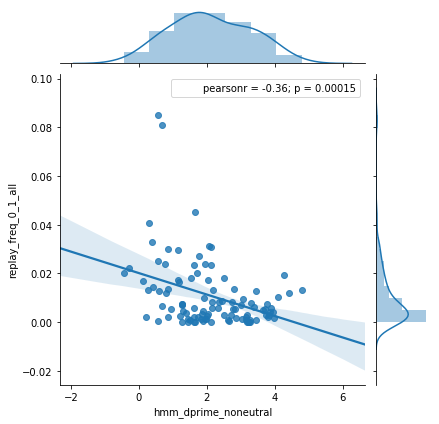

In [9]:
sns.jointplot(
    x='hmm_dprime_noneutral', y='replay_freq_0_1_all', data=data, kind='reg') 

                  Results: Generalized linear model
Model:                 GLM                   AIC:              -inf  
Link Function:         log                   BIC:              2.2255
Dependent Variable:    replay_freq_0_1_all   Log-Likelihood:   inf   
Date:                  2018-05-18 14:31      LL-Null:          inf   
No. Observations:      103                   Deviance:         470.33
Df Model:              1                     Pearson chi2:     118.  
Df Residuals:          101                   Scale:            1.1696
Method:                IRLS                                          
---------------------------------------------------------------------
                      Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Intercept            -3.8884   0.2206 -17.6291 0.0000 -4.3207 -3.4561
hmm_dprime_noneutral -0.3472   0.0914  -3.7984 0.0001 -0.5264 -0.1681



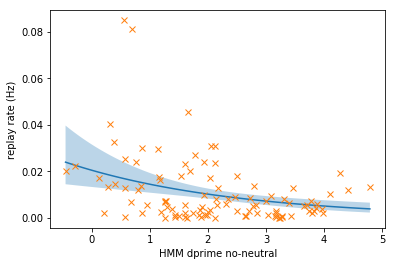

In [10]:
formula = 'replay_freq_0_1_all ~ hmm_dprime_noneutral'

data_sub = data[['replay_freq_0_1_all', 'mouse', 'hmm_dprime_noneutral']]
# 0s in the dependent variable still converges, but LL is infinite
# data_sub.replace(0, np.nan, inplace=True)
# data_sub.dropna(inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

exog = glm.exog
x_val = np.linspace(exog[:, 1].min(), exog[:, 1].max(), exog.shape[0])
exog[:, 1] = x_val
predict = glm_results.get_prediction(exog)

fig, ax = plt.subplots()
ax.plot(x_val, predict.predicted_mean)
ax.fill_between(x_val, predict.conf_int()[:, 0], predict.conf_int()[:, 1], alpha=0.3)
ax.plot(data_sub.hmm_dprime_noneutral, data_sub.replay_freq_0_1_all, 'x')
ax.set_xlabel('HMM dprime no-neutral')
ax.set_ylabel('replay rate (Hz)');

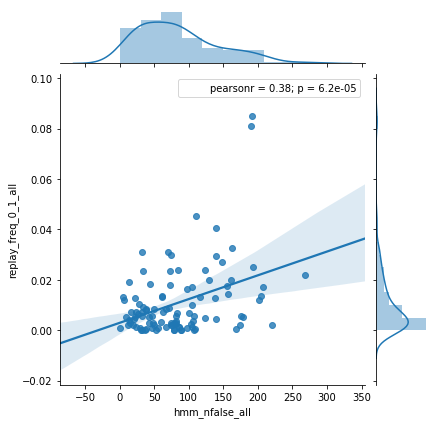

In [11]:
sns.jointplot(
    x='hmm_nfalse_all', y='replay_freq_0_1_all', data=data, kind='reg') 

               Results: Generalized linear model
Model:               GLM                 AIC:            -inf  
Link Function:       log                 BIC:            2.2407
Dependent Variable:  replay_freq_0_1_all Log-Likelihood: inf   
Date:                2018-05-18 14:31    LL-Null:        inf   
No. Observations:    103                 Deviance:       470.35
Df Model:            1                   Pearson chi2:   113.  
Df Residuals:        101                 Scale:          1.1171
Method:              IRLS                                      
---------------------------------------------------------------
                Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
---------------------------------------------------------------
Intercept      -5.2374   0.1851 -28.3008 0.0000 -5.6001 -4.8747
hmm_nfalse_all  0.0073   0.0018   4.0131 0.0001  0.0037  0.0108



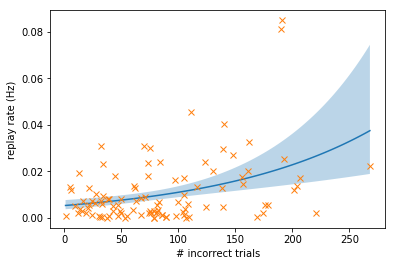

In [12]:
formula = 'replay_freq_0_1_all ~ hmm_nfalse_all'

data_sub = data[['replay_freq_0_1_all', 'mouse', 'hmm_nfalse_all']]
# 0s in the dependent variable still converges, but LL is infinite
# data_sub.replace(0, np.nan, inplace=True)
# data_sub.dropna(inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

exog = glm.exog
x_val = np.linspace(exog[:, 1].min(), exog[:, 1].max(), exog.shape[0])
exog[:, 1] = x_val
predict = glm_results.get_prediction(exog)

fig, ax = plt.subplots()
ax.plot(x_val, predict.predicted_mean)
ax.fill_between(x_val, predict.conf_int()[:, 0], predict.conf_int()[:, 1], alpha=0.3)
ax.plot(data_sub.hmm_nfalse_all, data_sub.replay_freq_0_1_all, 'x')
ax.set_xlabel('# incorrect trials')
ax.set_ylabel('replay rate (Hz)');

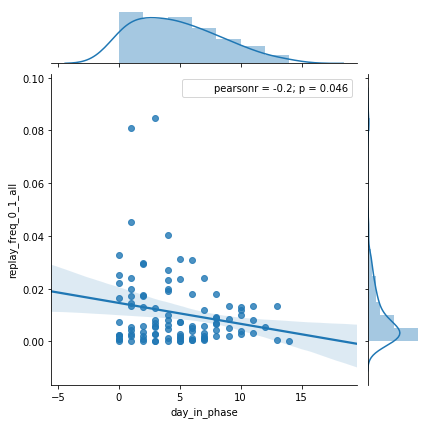

In [13]:
sns.jointplot(
    x='day_in_phase', y='replay_freq_0_1_all', data=data, kind='reg') 

## What is the interaction between reactivation, same day performance, and improvement
### Results
- consistently low reactivation when low performance and worse than yesterday
- higher reactivation when doing poorly but getting better
- looked possible, but not supported by stats

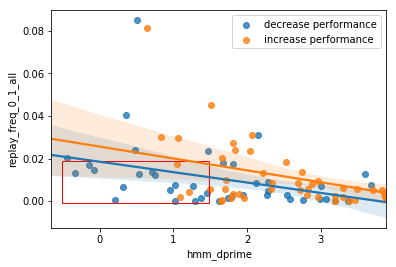

In [14]:
fig, ax = plt.subplots()
sns.regplot(
    ax=ax, y='replay_freq_0_1_all', x='hmm_dprime',
    data=data[data['d_hmm_dprime_prev'] < 0], label='decrease performance')
sns.regplot(
    ax=ax, y='replay_freq_0_1_all', x='hmm_dprime',
    data=data[data['d_hmm_dprime_prev'] > 0], label='increase performance')
rect = plt.Rectangle((-0.51, -0.001), 2.0, 0.02, fill=False, color='r')
ax.add_patch(rect)
ax.legend()

- rectangle highlights the low-reactivation, low-performance sessions, which all are decreasing performance sessions

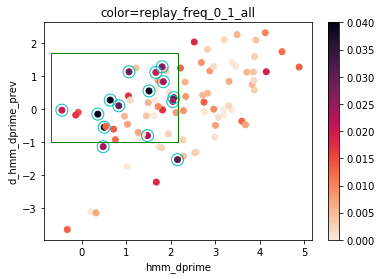

In [15]:
x = 'hmm_dprime'
y = 'd_hmm_dprime_prev'
hue = 'replay_freq_0_1_all'
# cmap = sns.cubehelix_palette(light=0.85, dark=0.15, as_cmap=True)
cmap = sns.cm.rocket_r

fig, ax = plt.subplots()
data_no_nan = data[[x, y, hue]]
data_no_nan.dropna(inplace=True)
x_data = np.array(data_no_nan[x])
y_data = np.array(data_no_nan[y])
hue_data = np.array(data_no_nan[hue])

plt.scatter(x_data, y_data, c=hue_data, cmap=cmap, vmax=0.04, s=36)
plt.colorbar(ax=ax)
plt.xlabel(x)
plt.ylabel(y)
plt.title('color={}'.format(hue))

top = hue_data.argsort()[-15:]
plt.scatter(x_data[top], y_data[top], edgecolor='c', marker='o', s=12**2, facecolor='none')

rect = plt.Rectangle((-0.7, -1), 2.85, 2.7, fill=False, color='g')
ax.add_patch(rect);

- rectangle highlights the low-performance, but improving sessions
- cyan circles are the 15 highest reactivation rate days

In [16]:
formula = 'replay_freq_0_1_all ~ d_hmm_dprime_prev * hmm_dprime'

data_sub = data[['replay_freq_0_1_all', 'mouse',
                 'd_hmm_dprime_prev', 'hmm_dprime']]

# 0s in the dependent variable still converges, but LL is infinite
data_sub.replace(0, np.nan, inplace=True)
data_sub.dropna(inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

                      Results: Generalized linear model
Model:                  GLM                     AIC:                -622.4462
Link Function:          log                     BIC:                -272.8276
Dependent Variable:     replay_freq_0_1_all     Log-Likelihood:     315.22   
Date:                   2018-05-18 14:31        LL-Null:            306.15   
No. Observations:       88                      Deviance:           103.27   
Df Model:               3                       Pearson chi2:       92.5     
Df Residuals:           84                      Scale:              1.1011   
Method:                 IRLS                                                 
-----------------------------------------------------------------------------
                              Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
-----------------------------------------------------------------------------
Intercept                    -3.7086   0.2564 -14.4658 0.0000 -4.2111 -3.2061
d_hmm_dp

## Trial counts instead of rates
### Results
- reactivation rate strongest correlation with errors
- holds for both pre- and post-reversal, each trial type, and each replay type (not shown)

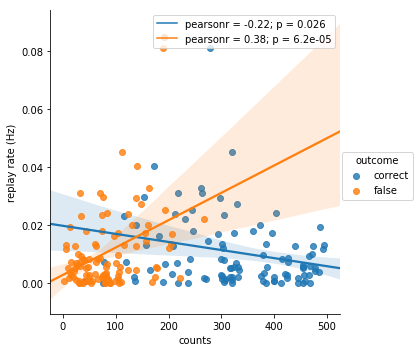

In [17]:
data_long = data[
    ['hmm_ncorrect_all', 'hmm_nfalse_all', 'replay_freq_0_1_all']]
data_long = data_long.melt(
    value_vars=['hmm_ncorrect_all', 'hmm_nfalse_all'],
    id_vars=['replay_freq_0_1_all'],
    var_name='outcome', value_name='counts')
data_long.outcome = data_long.outcome.apply(
    lambda x: 'correct' if 'correct' in x else 'false' if 'false' in x else 'ERROR')

g = sns.lmplot(
    x='counts', y='replay_freq_0_1_all',
    data=data_long, col_order=order, hue='outcome')
g.set_xlabels('counts')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

In [18]:
formula = 'replay_freq_0_1_all ~ hmm_ncorrect_all * hmm_nfalse_all'

data_sub = data[['replay_freq_0_1_all', 'mouse',
                 'hmm_ncorrect_all',
                 'hmm_nfalse_all']]

# 0s in the dependent variable still converges, but LL is infinite
data_sub.replace(0, np.nan, inplace=True)
data_sub.dropna(inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

                        Results: Generalized linear model
Model:                   GLM                      AIC:                 -695.5335
Link Function:           log                      BIC:                 -315.3669
Dependent Variable:      replay_freq_0_1_all      Log-Likelihood:      351.77   
Date:                    2018-05-18 14:31         LL-Null:             340.37   
No. Observations:        98                       Deviance:            115.62   
Df Model:                3                        Pearson chi2:        94.4     
Df Residuals:            94                       Scale:               1.0039   
Method:                  IRLS                                                   
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                       -5.4445   0.5254 -1

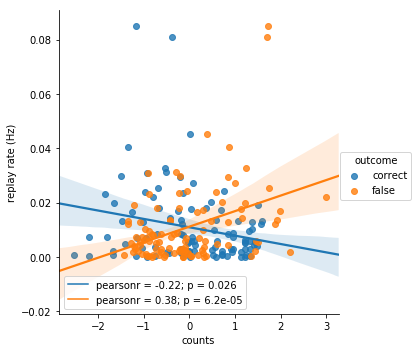

In [19]:
data_long = data[
    ['hmm_ncorrect_all', 'hmm_nfalse_all', 'replay_freq_0_1_all']]
from scipy.stats.mstats import zscore
data_long = data_long.assign(hmm_ncorrect_all=zscore(data_long.hmm_ncorrect_all),
                 hmm_nfalse_all=zscore(data_long.hmm_nfalse_all))
data_long = data_long.melt(
    value_vars=['hmm_ncorrect_all', 'hmm_nfalse_all'],
    id_vars=['replay_freq_0_1_all'],
    var_name='outcome', value_name='counts')
data_long.outcome = data_long.outcome.apply(
    lambda x: 'correct' if 'correct' in x else 'false' if 'false' in x else 'ERROR')

g = sns.lmplot(
    x='counts', y='replay_freq_0_1_all',
    data=data_long, col_order=order, hue='outcome')
g.set_xlabels('counts')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

In [20]:
formula = 'replay_freq_0_1_all ~ hmm_ncorrect_all * hmm_nfalse_all'

data_sub = data[['replay_freq_0_1_all', 'mouse',
                 'hmm_ncorrect_all',
                 'hmm_nfalse_all']]
from scipy.stats.mstats import zscore
data_sub = data_sub.assign(hmm_ncorrect_all=zscore(data_sub.hmm_ncorrect_all),
                 hmm_nfalse_all=zscore(data_sub.hmm_nfalse_all))

# 0s in the dependent variable still converges, but LL is infinite
data_sub.replace(0, np.nan, inplace=True)
data_sub.dropna(inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

                        Results: Generalized linear model
Model:                   GLM                      AIC:                 -695.5335
Link Function:           log                      BIC:                 -315.3669
Dependent Variable:      replay_freq_0_1_all      Log-Likelihood:      351.77   
Date:                    2018-05-18 14:31         LL-Null:             340.37   
No. Observations:        98                       Deviance:            115.62   
Df Model:                3                        Pearson chi2:        94.4     
Df Residuals:            94                       Scale:               1.0039   
Method:                  IRLS                                                   
--------------------------------------------------------------------------------
                                 Coef.  Std.Err.    z     P>|z|   [0.025  0.975]
--------------------------------------------------------------------------------
Intercept                       -4.6635   0.1130 -4

# Engagement

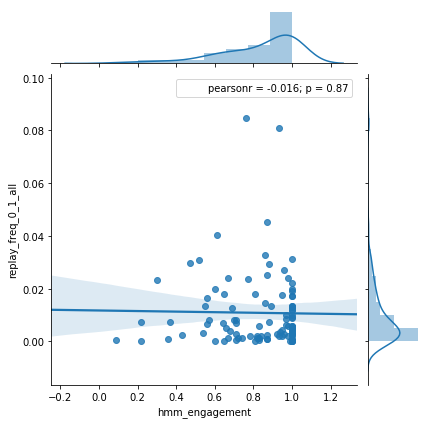

In [21]:
sns.jointplot(
    x='hmm_engagement', y='replay_freq_0_1_all', data=data, kind='reg') 

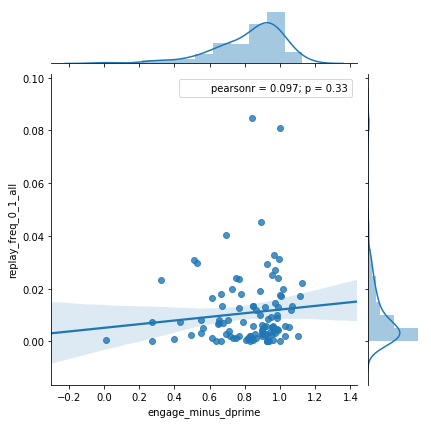

In [22]:
data_temp = data[['hmm_engagement', 'hmm_dprime', 'replay_freq_0_1_all']]

data_temp = data_temp.assign(
    engage_minus_dprime=jzap.analysis.regress_out(
        data_temp.hmm_engagement, data_temp.hmm_dprime))

sns.jointplot(
    x='engage_minus_dprime', y='replay_freq_0_1_all', data=data_temp, kind='reg') 

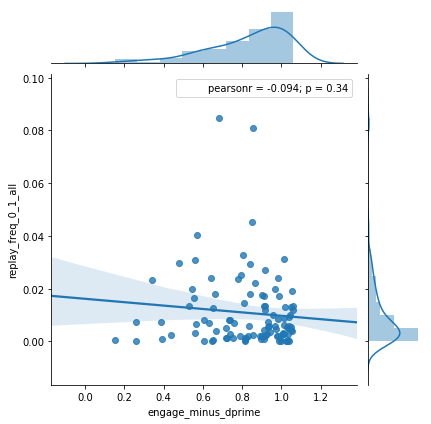

In [23]:
data_temp = data[['hmm_engagement', 'hmm_nfalse_all', 'replay_freq_0_1_all']]

data_temp = data_temp.assign(
    engage_minus_dprime=jzap.analysis.regress_out(
        data_temp.hmm_engagement, data_temp.hmm_nfalse_all))

sns.jointplot(
    x='engage_minus_dprime', y='replay_freq_0_1_all', data=data_temp, kind='reg') 

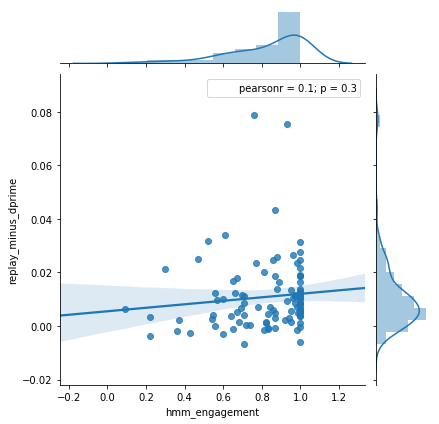

In [24]:
data_temp = data[['hmm_engagement', 'hmm_dprime', 'replay_freq_0_1_all']]

data_temp.dropna(subset=['replay_freq_0_1_all', 'hmm_dprime'], inplace=True)
data_temp = data_temp.assign(
    replay_minus_dprime=jzap.analysis.regress_out(
        data_temp.replay_freq_0_1_all, data_temp.hmm_dprime))

sns.jointplot(
    x='hmm_engagement', y='replay_minus_dprime', data=data_temp, kind='reg') 

In [25]:
formula = 'replay_freq_0_1_all ~ hmm_dprime * hmm_engagement'

data_sub = data[['replay_freq_0_1_all', 'mouse',
                 'hmm_dprime',
                 'hmm_engagement']]

# 0s in the dependent variable still converges, but LL is infinite
# data_sub.replace(0, np.nan, inplace=True)
# data_sub.dropna(inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

                    Results: Generalized linear model
Model:                   GLM                    AIC:               -inf  
Link Function:           log                    BIC:               9.8076
Dependent Variable:      replay_freq_0_1_all    Log-Likelihood:    inf   
Date:                    2018-05-18 14:31       LL-Null:           inf   
No. Observations:        103                    Deviance:          468.65
Df Model:                3                      Pearson chi2:      119.  
Df Residuals:            99                     Scale:             1.2070
Method:                  IRLS                                            
-------------------------------------------------------------------------
                           Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
-------------------------------------------------------------------------
Intercept                 -3.7188   0.7984 -4.6575 0.0000 -5.2837 -2.1538
hmm_dprime                -0.8211   0.4071 -2.0172 0.0437 

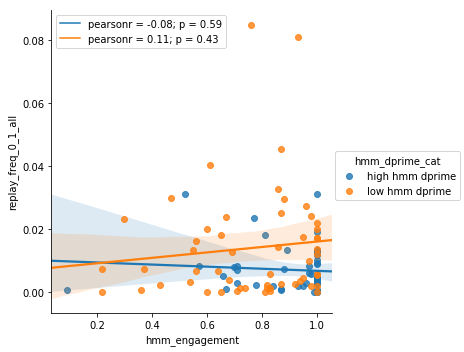

In [26]:
g = sns.lmplot(
    x='hmm_engagement', y='replay_freq_0_1_all', hue='hmm_dprime_cat',
    data=data)
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

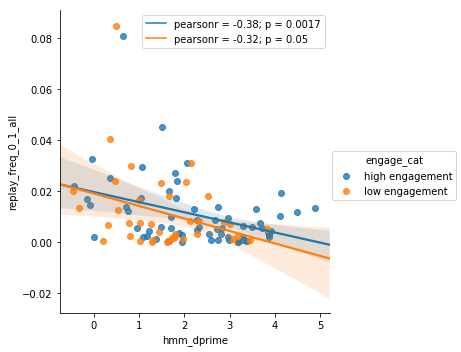

In [27]:
g = sns.lmplot(
    hue='engage_cat', y='replay_freq_0_1_all', x='hmm_dprime',
    data=data)
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

# D dprime

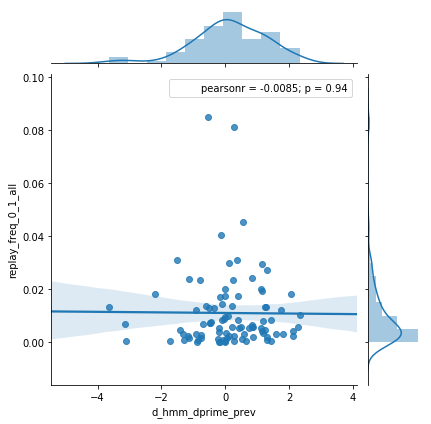

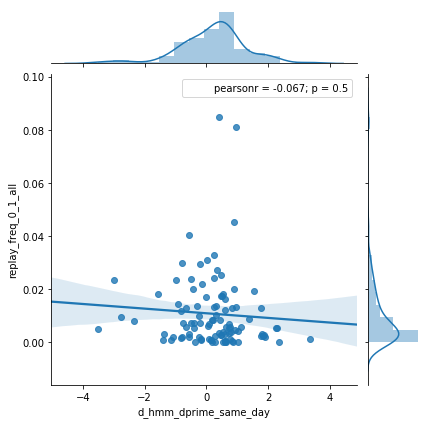

In [28]:
sns.jointplot(
    x='d_hmm_dprime_prev', y='replay_freq_0_1_all', data=data, kind='reg') 
sns.jointplot(
    x='d_hmm_dprime_same_day', y='replay_freq_0_1_all', data=data, kind='reg') 

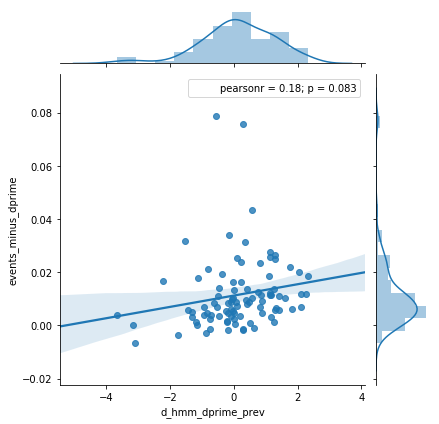

In [29]:
data_long = data[
    ['replay_freq_0_1_all', 'hmm_dprime',
     'd_hmm_dprime_prev']]

data_long.dropna(subset=['replay_freq_0_1_all', 'hmm_dprime'], inplace=True)
data_long = data_long.assign(
    events_minus_dprime=jzap.analysis.regress_out(
        data_long.replay_freq_0_1_all, data_long.hmm_dprime))

sns.jointplot(x='d_hmm_dprime_prev', y='events_minus_dprime', data=data_long, kind='reg')

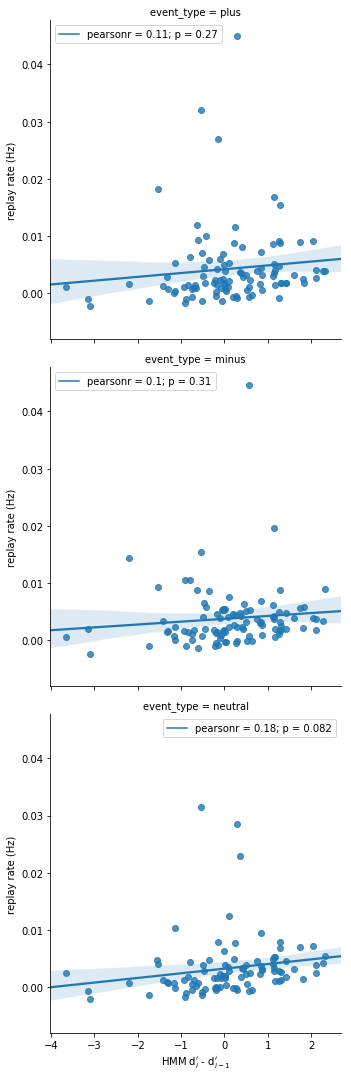

In [30]:
data_long = data[
    ['replay_freq_0_1_plus', 'replay_freq_0_1_neutral',
     'replay_freq_0_1_minus', 'hmm_dprime',
     'd_hmm_dprime_prev']]
data_long = data_long.melt(
    value_vars=['replay_freq_0_1_plus', 'replay_freq_0_1_minus',
                'replay_freq_0_1_neutral'],
    id_vars=['hmm_dprime',
             'd_hmm_dprime_prev'],
    var_name='event_type', value_name='events')
data_long.event_type = data_long.event_type.map(
    {'replay_freq_0_1_plus': 'plus', 'replay_freq_0_1_minus': 'minus',
     'replay_freq_0_1_neutral': 'neutral'})

data_long.dropna(subset=['events', 'hmm_dprime'], inplace=True)
data_long = data_long.assign(
    events_minus_dprime=jzap.analysis.regress_out(
        data_long.events, data_long.hmm_dprime))

g = sns.lmplot(
    x='d_hmm_dprime_prev', y='events_minus_dprime', row='event_type',
    data=data_long, row_order=order, col_order=order)
g.set_xlabels(r'HMM d$^\prime_{i}$ - d$^\prime_{i-1}$')
g.set_ylabels('replay rate (Hz)')
jzap.plotting.misc.add_stats_to_facet_grid(g, scipy.stats.pearsonr)

# Neutral Replay

In [31]:
formula = 'replay_freq_0_1_all ~ hmm_behavior_plus + hmm_behavior_minus + hmm_behavior_neutral'

data_sub = data[['replay_freq_0_1_all', 'mouse',
                 'hmm_behavior_plus', 'hmm_behavior_minus', 'hmm_behavior_neutral']]

# 0s in the dependent variable still converges, but LL is infinite
data_sub.replay_freq_0_1_all.replace(0, np.nan, inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

                  Results: Generalized linear model
Model:               GLM                  AIC:             -694.7152
Link Function:       log                  BIC:             -314.6877
Dependent Variable:  replay_freq_0_1_all  Log-Likelihood:  351.36   
Date:                2018-05-18 14:31     LL-Null:         339.95   
No. Observations:    98                   Deviance:        116.30   
Df Model:            3                    Pearson chi2:    91.5     
Df Residuals:        94                   Scale:           0.97373  
Method:              IRLS                                           
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept            -1.7705   0.6114 -2.8957 0.0038 -2.9688 -0.5721
hmm_behavior_plus    -1.6118   0.6386 -2.5240 0.0116 -2.8634 -0.3602
hmm_behavior_minus   -3.1534   1.0006 -3.1516 0.001

In [32]:
formula = 'replay_freq_0_1_plus ~ hmm_behavior_plus + hmm_behavior_minus + hmm_behavior_neutral'

data_sub = data[['replay_freq_0_1_plus', 'mouse',
                 'hmm_behavior_plus', 'hmm_behavior_minus', 'hmm_behavior_neutral']]

# 0s in the dependent variable still converges, but LL is infinite
data_sub.replay_freq_0_1_plus.replace(0, np.nan, inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

                  Results: Generalized linear model
Model:                GLM                  AIC:            -840.4330
Link Function:        log                  BIC:            -299.8084
Dependent Variable:   replay_freq_0_1_plus Log-Likelihood: 424.22   
Date:                 2018-05-18 14:31     LL-Null:        407.02   
No. Observations:     94                   Deviance:       109.09   
Df Model:             3                    Pearson chi2:   93.4     
Df Residuals:         90                   Scale:          1.0375   
Method:               IRLS                                          
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept            -2.3151   0.6022 -3.8446 0.0001 -3.4953 -1.1349
hmm_behavior_plus    -1.0782   0.6501 -1.6585 0.0972 -2.3523  0.1960
hmm_behavior_minus   -4.9231   1.0248 -4.8039 0.000

In [33]:
formula = 'replay_freq_0_1_minus ~ hmm_behavior_plus + hmm_behavior_minus + hmm_behavior_neutral'

data_sub = data[['replay_freq_0_1_minus', 'mouse',
                 'hmm_behavior_plus', 'hmm_behavior_minus', 'hmm_behavior_neutral']]

# 0s in the dependent variable still converges, but LL is infinite
data_sub.replay_freq_0_1_minus.replace(0, np.nan, inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

                  Results: Generalized linear model
Model:               GLM                   AIC:            -842.5312
Link Function:       log                   BIC:            -315.1543
Dependent Variable:  replay_freq_0_1_minus Log-Likelihood: 425.27   
Date:                2018-05-18 14:31      LL-Null:        423.18   
No. Observations:    97                    Deviance:       110.29   
Df Model:            3                     Pearson chi2:   187.     
Df Residuals:        93                    Scale:          2.0082   
Method:              IRLS                                           
--------------------------------------------------------------------
                      Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
--------------------------------------------------------------------
Intercept            -3.7172   0.8608 -4.3181 0.0000 -5.4044 -2.0300
hmm_behavior_plus    -1.2159   0.9048 -1.3439 0.1790 -2.9893  0.5575
hmm_behavior_minus   -1.5758   1.4570 -1.0815 0.279

In [34]:
formula = 'replay_freq_0_1_neutral ~ hmm_behavior_plus + hmm_behavior_minus + hmm_behavior_neutral'

data_sub = data[['replay_freq_0_1_neutral', 'mouse',
                 'hmm_behavior_plus', 'hmm_behavior_minus', 'hmm_behavior_neutral']]

# 0s in the dependent variable still converges, but LL is infinite
data_sub.replay_freq_0_1_neutral.replace(0, np.nan, inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

                  Results: Generalized linear model
Model:              GLM                     AIC:            -816.2389
Link Function:      log                     BIC:            -281.8848
Dependent Variable: replay_freq_0_1_neutral Log-Likelihood: 412.12   
Date:               2018-05-18 14:31        LL-Null:        402.19   
No. Observations:   88                      Deviance:       94.212   
Df Model:           3                       Pearson chi2:   95.0     
Df Residuals:       84                      Scale:          1.1304   
Method:             IRLS                                             
---------------------------------------------------------------------
                       Coef.  Std.Err.    z    P>|z|   [0.025  0.975]
---------------------------------------------------------------------
Intercept             -3.2157   0.6716 -4.7880 0.0000 -4.5320 -1.8993
hmm_behavior_plus     -0.7935   0.7130 -1.1130 0.2657 -2.1910  0.6039
hmm_behavior_minus    -1.9798   1.1089

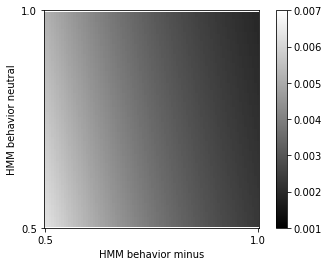

In [35]:
cmap = plt.get_cmap('binary_r')
# cmap = sns.cm.rocket_r

formula = 'replay_freq_0_1_neutral ~ hmm_behavior_plus + hmm_behavior_minus + hmm_behavior_neutral'

data_sub = data[['replay_freq_0_1_neutral', 'mouse',
                 'hmm_behavior_plus', 'hmm_behavior_minus', 'hmm_behavior_neutral']]

# 0s in the dependent variable still converges, but LL is infinite
data_sub.replay_freq_0_1_neutral.replace(0, np.nan, inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()

exog = glm.exog
# x1_range = (exog[:, 2:4].min(), exog[:, 2:4].max())
# x1_range = (0., 1.)
x1_range = (0.5, 1.)
x2_range = x1_range
x1_val = np.linspace(x1_range[0], x1_range[1], exog.shape[0])
x2_val = np.linspace(x1_range[0], x1_range[1], exog.shape[0])
x1_val_mesh, x2_val_mesh = np.meshgrid(x1_val, x2_val)
new_exog = np.ones((np.prod(x1_val_mesh.shape), 4))
new_exog[:, 1] = glm.exog[:, 1].mean()
new_exog[:, 2] = x1_val_mesh.flat
# new_exog[:, 3] = np.multiply(x1_val_mesh.flat, x2_val_mesh.flat)
new_exog[:, 3] = x2_val_mesh.flat
predict = glm_results.get_prediction(new_exog)

fig, ax = plt.subplots()
predict_react = np.reshape(predict.predicted_mean, x1_val_mesh.shape)
plt.imshow(np.flipud(predict_react),
          cmap=cmap, vmin=0.001, vmax=0.007)
# plt.imshow(np.flipud(predict_react),
#           cmap=cmap, vmin=predict_react.min(), vmax=predict_react.max())
plt.colorbar()
ax.set_xticks([ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5])
ax.set_xticklabels(x1_range)
ax.set_yticks([ax.get_ylim()[0] + 0.5, ax.get_ylim()[1] - 0.5])
ax.set_yticklabels(x2_range)
ax.set_xlabel('HMM behavior minus')
ax.set_ylabel('HMM behavior neutral');

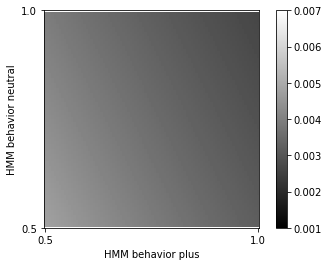

In [36]:
cmap = plt.get_cmap('binary_r')
# cmap = sns.cm.rocket_r

formula = 'replay_freq_0_1_neutral ~ hmm_behavior_plus + hmm_behavior_minus + hmm_behavior_neutral'

data_sub = data[['replay_freq_0_1_neutral', 'mouse',
                 'hmm_behavior_plus', 'hmm_behavior_minus', 'hmm_behavior_neutral']]

# 0s in the dependent variable still converges, but LL is infinite
data_sub.replay_freq_0_1_neutral.replace(0, np.nan, inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()

exog = glm.exog
# x1_range = (exog[:, 2:4].min(), exog[:, 2:4].max())
# x1_range = (0., 1.)
x1_range = (0.5, 1.)
x2_range = x1_range
x1_val = np.linspace(x1_range[0], x1_range[1], exog.shape[0])
x2_val = np.linspace(x1_range[0], x1_range[1], exog.shape[0])
x1_val_mesh, x2_val_mesh = np.meshgrid(x1_val, x2_val)
new_exog = np.ones((np.prod(x1_val_mesh.shape), 4))
new_exog[:, 1] = x1_val_mesh.flat
new_exog[:, 2] = exog[:, 2].mean()
# new_exog[:, 3] = np.multiply(x1_val_mesh.flat, x2_val_mesh.flat)
new_exog[:, 3] = x2_val_mesh.flat
predict = glm_results.get_prediction(new_exog)

fig, ax = plt.subplots()
predict_react = np.reshape(predict.predicted_mean, x1_val_mesh.shape)
# plt.imshow(np.flipud(predict_react),
#           cmap=cmap, vmin=predict_react.min(), vmax=predict_react.max())
plt.imshow(np.flipud(predict_react),
          cmap=cmap, vmin=0.001, vmax=0.007)
plt.colorbar()
ax.set_xticks([ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5])
ax.set_xticklabels(x1_range)
ax.set_yticks([ax.get_ylim()[0] + 0.5, ax.get_ylim()[1] - 0.5])
ax.set_yticklabels(x2_range)
ax.set_xlabel('HMM behavior plus')
ax.set_ylabel('HMM behavior neutral');

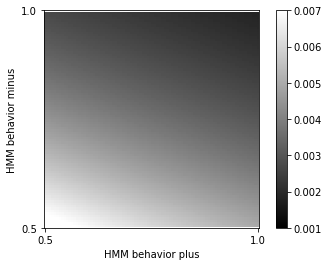

In [37]:
cmap = plt.get_cmap('binary_r')
# cmap = sns.cm.rocket_r

formula = 'replay_freq_0_1_neutral ~ hmm_behavior_plus + hmm_behavior_minus + hmm_behavior_neutral'

data_sub = data[['replay_freq_0_1_neutral', 'mouse',
                 'hmm_behavior_plus', 'hmm_behavior_minus', 'hmm_behavior_neutral']]

# 0s in the dependent variable still converges, but LL is infinite
data_sub.replay_freq_0_1_neutral.replace(0, np.nan, inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()

exog = glm.exog
# x1_range = (exog[:, 2:4].min(), exog[:, 2:4].max())
# x1_range = (0., 1.)
x1_range = (0.5, 1.)
x2_range = x1_range
x1_val = np.linspace(x1_range[0], x1_range[1], exog.shape[0])
x2_val = np.linspace(x1_range[0], x1_range[1], exog.shape[0])
x1_val_mesh, x2_val_mesh = np.meshgrid(x1_val, x2_val)
new_exog = np.ones((np.prod(x1_val_mesh.shape), 4))
new_exog[:, 1] = x1_val_mesh.flat
new_exog[:, 2] = x2_val_mesh.flat
# new_exog[:, 3] = np.multiply(x1_val_mesh.flat, x2_val_mesh.flat)
new_exog[:, 3] = exog[:, 2].mean()
predict = glm_results.get_prediction(new_exog)

fig, ax = plt.subplots()
predict_react = np.reshape(predict.predicted_mean, x1_val_mesh.shape)
# plt.imshow(np.flipud(predict_react),
#           cmap=cmap, vmin=predict_react.min(), vmax=predict_react.max())
plt.imshow(np.flipud(predict_react),
          cmap=cmap, vmin=0.001, vmax=0.007)
plt.colorbar()
ax.set_xticks([ax.get_xlim()[0] + 0.5, ax.get_xlim()[1] - 0.5])
ax.set_xticklabels(x1_range)
ax.set_yticks([ax.get_ylim()[0] + 0.5, ax.get_ylim()[1] - 0.5])
ax.set_yticklabels(x2_range)
ax.set_xlabel('HMM behavior plus')
ax.set_ylabel('HMM behavior minus');

                Results: Generalized linear model
Model:              GLM                  AIC:            -inf    
Link Function:      log                  BIC:            997.0948
Dependent Variable: replay_freq_0_1_plus Log-Likelihood: inf     
Date:               2018-05-18 14:31     LL-Null:        inf     
No. Observations:   114                  Deviance:       1527.5  
Df Model:           1                    Pearson chi2:   212.    
Df Residuals:       112                  Scale:          1.8962  
Method:             IRLS                                         
------------------------------------------------------------------
              Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
------------------------------------------------------------------
Intercept    -4.8543    0.2474  -19.6213  0.0000  -5.3392  -4.3694
hmm_dprime   -0.4007    0.1062   -3.7748  0.0002  -0.6088  -0.1927



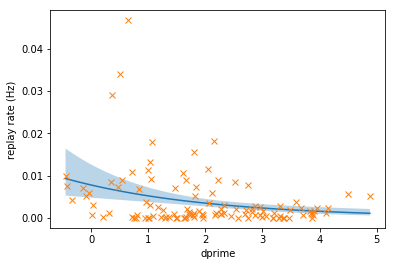

In [38]:
formula = 'replay_freq_0_1_plus ~ hmm_dprime'

data_sub = data[['replay_freq_0_1_plus', 'mouse', 'hmm_dprime']]
# 0s in the dependent variable still converges, but LL is infinite
# data_sub.replace(0, np.nan, inplace=True)
# data_sub.dropna(inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

exog = glm.exog
x_val = np.linspace(exog[:, 1].min(), exog[:, 1].max(), exog.shape[0])
exog[:, 1] = x_val
predict = glm_results.get_prediction(exog)

fig, ax = plt.subplots()
ax.plot(x_val, predict.predicted_mean)
ax.fill_between(x_val, predict.conf_int()[:, 0], predict.conf_int()[:, 1], alpha=0.3)
ax.plot(data_sub.hmm_dprime, data_sub.replay_freq_0_1_plus, 'x')
ax.set_xlabel('dprime')
ax.set_ylabel('replay rate (Hz)');

                 Results: Generalized linear model
Model:              GLM                   AIC:            -inf    
Link Function:      log                   BIC:            581.5670
Dependent Variable: replay_freq_0_1_minus Log-Likelihood: inf     
Date:               2018-05-18 14:31      LL-Null:        inf     
No. Observations:   111                   Deviance:       1094.9  
Df Model:           1                     Pearson chi2:   237.    
Df Residuals:       109                   Scale:          2.1751  
Method:             IRLS                                          
-------------------------------------------------------------------
               Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
-------------------------------------------------------------------
Intercept     -5.2334    0.2704  -19.3560  0.0000  -5.7634  -4.7035
hmm_dprime    -0.2067    0.1148   -1.7995  0.0719  -0.4317   0.0184



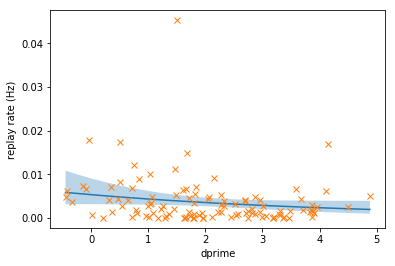

In [39]:
formula = 'replay_freq_0_1_minus ~ hmm_dprime'

data_sub = data[['replay_freq_0_1_minus', 'mouse', 'hmm_dprime']]
# 0s in the dependent variable still converges, but LL is infinite
# data_sub.replace(0, np.nan, inplace=True)
# data_sub.dropna(inplace=True)

y, X = patsy.dmatrices(formula, data_sub, return_type='dataframe')
X = sm.add_constant(X)

family = sm.families.Gamma(link=sm.families.links.log)

glm = sm.GLM(y, X, family=family)
glm_results = glm.fit()
print(glm_results.summary2())

exog = glm.exog
x_val = np.linspace(exog[:, 1].min(), exog[:, 1].max(), exog.shape[0])
exog[:, 1] = x_val
predict = glm_results.get_prediction(exog)

fig, ax = plt.subplots()
ax.plot(x_val, predict.predicted_mean)
ax.fill_between(x_val, predict.conf_int()[:, 0], predict.conf_int()[:, 1], alpha=0.3)
ax.plot(data_sub.hmm_dprime, data_sub.replay_freq_0_1_minus, 'x')
ax.set_xlabel('dprime')
ax.set_ylabel('replay rate (Hz)');